In [1]:
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

np.random.seed(1337)

In [3]:
def point_inside_circle(node1, obstacle) -> bool:
    """Calculates if a points falls inside an obstacle

    Args:
        node1 (Tuple[float, float]): Sampled node
        obstacle (Tuple[float, float, float]): Obstacle to be checked

    Returns:
        bool: True if node falls inside obstacle, else False
    """
    cx, cy, r = obstacle
    x1, y1 = node1
    # Check if point is inside the circle
    return False if math.sqrt((x1 - cx) ** 2 + (y1 - cy) ** 2) > r else True


def circle_line_intersection(node1, node2, obstacle) -> bool:
    """Check if line intersects with circle

    Args:
        node1 (_type_): The (x, y) location of the first node
        node2 (_type_): The (x, y) location of the second node
        obstacle (_type_): The (x, y, r) location and radius of the obstacle

    Returns:
        bool: True if line intersectecs with circle, else False
    """

    from shapely.geometry import LineString, Point

    x1, y1 = node1
    x2, y2 = node2
    cx, cy, r = obstacle

    p_o = Point((cx, cy))
    c = p_o.buffer(r).boundary
    l = LineString([(x1, y1), (x2, y2)])
    i = c.intersection(l)

    return False if i.is_empty else True


In [4]:
def find_k_nearest_neighbors(nodes, k):
    """Findes the indicies of the K nearest neighbors of to any give node

    Args:
        nodes (List[Tuple[float, float]]): List of the nodes positions
        k (int): Number of nearest nodes to connect to

    Returns:
        dict: dictionary where the key-value pairs are:  node_idx: [neighbor_1_idx, neighbor_2_idx, ..., neighbor_k_idx]
    """
    node_neighbors = defaultdict(list)

    for i, node1 in enumerate(nodes):
        distances = []
        for j, node2 in enumerate(nodes):
            if i != j:
                (x1, y1), (x2, y2) = node1, node2
                dist = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                distances.append((dist, j))
        k_nearest = sorted(distances)[:k]
        for _, neighbor_idx in k_nearest:
            node_neighbors[i].append(neighbor_idx)

    return node_neighbors


In [5]:
class PRM:
    def __init__(self, num_nodes, map_size, num_neighbors):
        self.num_nodes = num_nodes
        self.map_size = map_size
        self.num_neighbors = num_neighbors
        self.obstacles = []
        self.nodes = []
        self.node_neighbors = None
        self.edges = defaultdict(list)

        self.start = None
        self.start_idx = None

        self.goal = None
        self.goal_idx = None

    def generate_random_nodes(self):
        for _ in range(self.num_nodes):
            collides = True
            while collides:
              x = np.random.uniform(0, self.map_size)
              y = np.random.uniform(0, self.map_size)
              # Check if nodes collides with obstacles
              node = (x, y)
              if not self.collides_with_obstacle(node):
                collides = False
            self.nodes.append(node)

    def compute_edges(self):
        # Calculate the k-nearest neighbors, and store them for future use.
        self.node_neighbors = find_k_nearest_neighbors(self.nodes, self.num_neighbors)

        # For each neighbor, check if the direct path is obstacle free.

        for i, node in enumerate(self.nodes):
            for neighbor_idx in self.node_neighbors[i]:
                neighbor = self.nodes[neighbor_idx]
                # If path is free, calculate distance and create the edge
                if not self.path_collides_obstacle(node, neighbor):
                    dist = math.sqrt(
                        (node[0] - neighbor[0]) ** 2 + (node[1] - neighbor[1]) ** 2
                    )
                    self.edges[i].append((neighbor_idx, dist))

    def collides_with_obstacle(self, node1):
        for obstacle in self.obstacles:
            if point_inside_circle(node1, obstacle):
                return True
        return False

    def path_collides_obstacle(self, node1, node2):
        for obstacle in self.obstacles:
            if circle_line_intersection(node1, node2, obstacle):
                return True
        return False

    def add_start_and_goal(self, start, goal):
        if self.collides_with_obstacle(start):
            print("Error: Starting point is not valid")
            exit(-1)

        if self.collides_with_obstacle(goal):
            print("Error: Goal point is not valid")
            exit(-1)

        # Set start and goal positions, and add them to the nodes
        self.start, self.goal = start, goal

        self.start_idx = len(self.nodes)
        self.nodes.append(start)

        self.goal_idx = len(self.nodes)
        self.nodes.append(goal)

        # Find nearest node
        neighbours = find_k_nearest_neighbors(self.nodes, k=1)
        # Get the closest (first) neighbour to the star and goal positions
        goal_neighbour_idx = neighbours[self.goal_idx][0]
        start_neighbour_idx = neighbours[self.start_idx][0]

        goal_neighbour = self.nodes[goal_neighbour_idx]
        start_neighbour = self.nodes[start_neighbour_idx]

        # computed distances
        d_goal = math.sqrt((goal[0] - goal_neighbour[0]) ** 2 + (goal[1] - goal_neighbour[1]) ** 2)
        d_start = math.sqrt((start[0] - start_neighbour[0]) ** 2 + (start[1] - start_neighbour[1]) ** 2)

        print(self.edges[goal_neighbour])
        self.edges[goal_neighbour].append((self.goal_idx, d_goal))
        self.edges[start_neighbour].append((self.start_idx, d_start))

    def add_obstacle(self, x, y, radius):
        self.obstacles.append((x, y, radius))

    def plot(self):
        plt.figure(dpi=150)
        for node_idx, edges in self.edges.items():
            for edge in edges:
                node1 = self.nodes[node_idx]
                node2 = self.nodes[edge[0]]
                plt.plot([node1[0], node2[0]], [node1[1], node2[1]], "b-")
        for node in self.nodes:
            plt.plot(node[0], node[1], "ro")
        for obstacle in self.obstacles:
            circle = plt.Circle(
                (obstacle[0], obstacle[1]), obstacle[2], color="gray", alpha=0.5
            )
            plt.gca().add_patch(circle)

        if self.goal:
            plt.plot(self.goal[0], self.goal[1], "yo")
        if self.start:
            plt.plot(self.start[0], self.start[1], "go")

        plt.title("Probabilistic Roadmap with Obstacles")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.show()

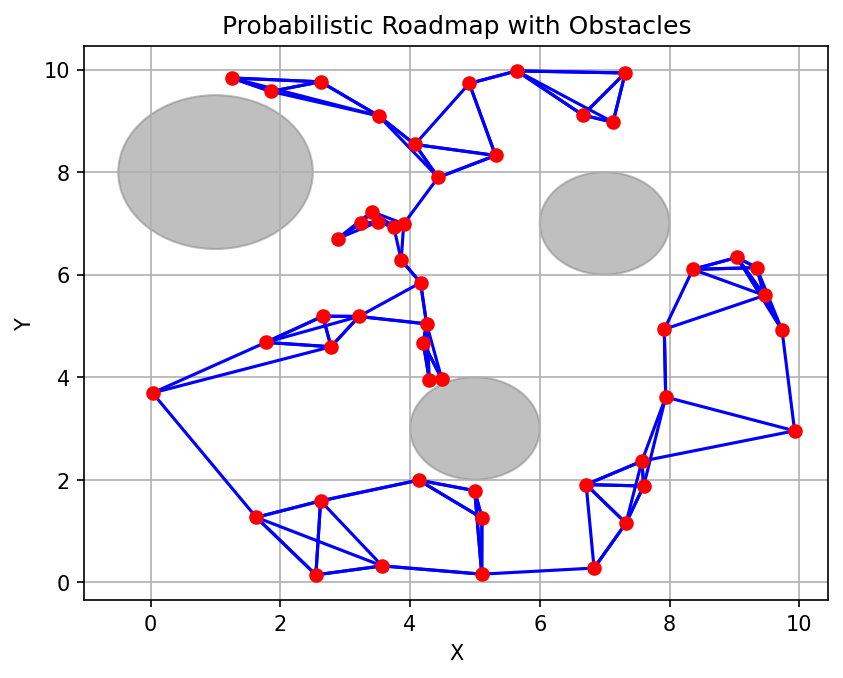

In [6]:
map_size = 10  # Map size in both x, and y dimensions
num_nodes = 50  # Number of nodes to sampled
num_neighbors = 3  # Number of connected neighbors to each node

# Create the Probabilistic Roadmap
prm = PRM(num_nodes, map_size, num_neighbors)

# Add obstacles
prm.add_obstacle(5, 3, 1)
prm.add_obstacle(7, 7, 1)
prm.add_obstacle(1, 8, 1.5)

# Sample the state space and connect the nodes
prm.generate_random_nodes()
prm.compute_edges()

# Plot the final road Map
prm.plot()

[]


TypeError: list indices must be integers or slices, not tuple

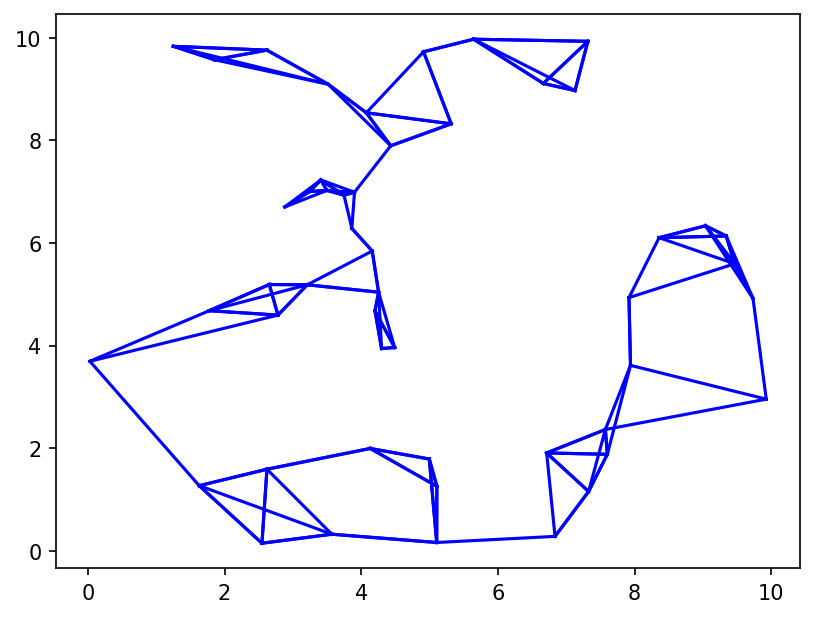

In [7]:
# Add starting and ending positions
prm.add_start_and_goal(start=(0, 0), goal=(10, 10))
prm.plot()

In [ ]:
def dijkstra(edges, start_idx, goal_idx):
    distances = {}
    # You code goes here!
    return distances


In [ ]:
prm.edges[prm.goal_idx-2]

Map Shape: (164, 311)
Unique values in the map: [155 255]


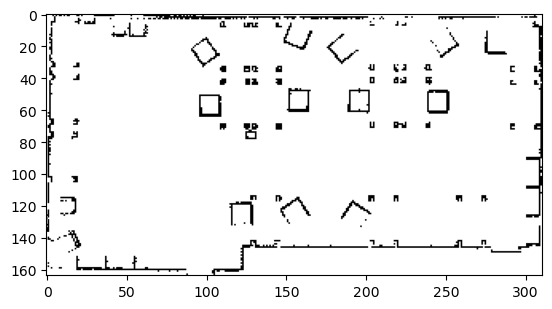

In [2]:
import numpy as np
import matplotlib.pyplot as plt

map = np.load('map.npy')

print(f'Map Shape: {map.shape}')
print(f'Unique values in the map: {np.unique(map)}')
plt.imshow(map, cmap='gray')

(0.0, 5.0)

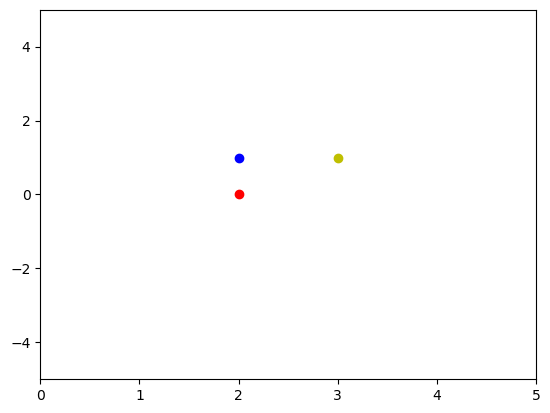

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

pt1 = np.array([2,0,1])

o = np.array([2,1,1])
R = Rotation.from_euler('z', 90, degrees=True)

pt2 = R.apply(pt1)
pt3 = R.apply(pt1 - o) + o


plt.scatter(pt1[0], pt1[1], c='r')
plt.scatter(o[0], o[1], c='b')
plt.scatter(pt2[0], pt2[1], c='g')
plt.scatter(pt3[0], pt3[1], c='y')
plt.ylim(-5, 5)
plt.xlim(0, 5)